# XGBoost

## Libraries

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns

from NanashiFunctions import apply_nanashi_data_processing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

## Data Read and Processing

The data is gathered from the [House Prices Competition]("https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques") of Kaggle. The data processing has been borrowed from Nanashi [Kaggle Notebook]("https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1#Models")

In [2]:
# Reading the data and printing the shape of the dataframes
train = pd.read_csv("./house_prices_data/train.csv")
test = pd.read_csv("./house_prices_data/test.csv")

# Apply the data processing that Nanashi does in his notebook
X, y, X_submission = apply_nanashi_data_processing(train, test)

# The X_submission is only used for subimt predictions to the Kaggle competition. So only the X and y are used.
# With this X and y, we save a 15% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

C:\Users\jmlga\anaconda3\envs\go_daddy_competition\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\jmlga\anaconda3\envs\go_daddy_competition\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


## Training XGBoost

### Baseline

Defining a baseline model (with default parameters) and calculating its MAE

In [3]:
# Defining the baseline model  without tuning any parameter
model = xgb.XGBRegressor(random_state=42)
results = cross_validate(model, X_train, y_train, cv=5,
                         return_train_score=True, scoring="neg_mean_absolute_error")
results

{'fit_time': array([1.22493076, 1.2520895 , 2.02006865, 1.88043666, 2.09508371]),
 'score_time': array([0.01500869, 0.03074574, 0.03125644, 0.03151131, 0.03129339]),
 'test_score': array([-0.09845517, -0.09697228, -0.10221193, -0.09179208, -0.09095945]),
 'train_score': array([-0.0033843 , -0.00485346, -0.00511829, -0.00654033, -0.00482065])}

In [4]:
# Getting the mean score of the 5 folds (either from train and test)
baseline_mean_train_score = np.multiply(results["train_score"], -1).mean()
baseline_mean_test_score = np.multiply(results["test_score"], -1).mean()

print("Baseline Results")
print(f"Train Score (mean): {baseline_mean_train_score}")
print(f"Test Score (mean): {baseline_mean_test_score}")

Baseline Results
Train Score (mean): 0.00494340544271917
Test Score (mean): 0.09607818108473462


### First GridSearchCV

In [6]:
# Defining the parameters grid
parameters_grid = {'max_depth': [4, 5, 6], 
                   'learning_rate': [0.1, 0.2, 0.3],
                   'n_estimators': [50, 100, 150], 
                   'gamma': [0, 20], 
                   'subsample': [0.8, 1], 
                   'colsample_bytree': [0.8, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

xgboost = xgb.XGBRegressor()

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1], 'eval_metric': ['mae'],
                         'gamma': [0, 20], 'lambda': [0, 0.1, 1],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1], 'tree_method': ['hist']},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [11]:
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

,colsample_bytree,eval_metric,gamma,lambda,learning_rate,max_depth,n_estimators,subsample,tree_method,test_mean_mae,train_mean_mae
437,1.0,mae,0,1.0,0.1,4,150,1.0,hist,-0.083953,-0.037465
59,0.8,mae,0,0.1,0.1,4,150,1.0,hist,-0.084377,-0.035801
64,0.8,mae,0,0.1,0.1,5,150,0.8,hist,-0.084506,-0.023213
119,0.8,mae,0,1.0,0.1,5,150,1.0,hist,-0.084546,-0.027149
112,0.8,mae,0,1.0,0.1,4,150,0.8,hist,-0.084548,-0.037094
...,...,...,...,...,...,...,...,...,...,...,...
174,0.8,mae,20,0.0,0.1,6,50,0.8,hist,-0.217818,-0.216474
168,0.8,mae,20,0.0,0.1,5,50,0.8,hist,-0.217818,-0.216474
222,0.8,mae,20,0.1,0.1,5,50,0.8,hist,-0.219164,-0.218183
216,0.8,mae,20,0.1,0.1,4,50,0.8,hist,-0.219164,-0.218183


In [39]:
# Now the baseline has changed
best_score = abs(cv_results.sort_values(by="test_mean_mae", ascending=False).iloc[0]["test_mean_mae"])

### Individual parameters

In [40]:
def get_cross_validate_scores(df_scores, feature, value, model, X_train, y_train, best_score, metric="neg_mean_absolute_error"):
    # Train the model with cross_validation and get the results
    results = cross_validate(model, X_train, y_train, cv=5,
                             return_train_score=True, scoring=metric)
    # Calculate the metrics
    mean_train_score = np.multiply(results["train_score"], -1).mean()
    mean_test_score = np.multiply(results["test_score"], -1).mean()
    
    # Create different rows to add to the scores.
    print(f"{feature}: {value} - Train Score: {mean_train_score} - Test Score: {mean_test_score}")
    
    train_row_df = pd.DataFrame.from_dict({"value": value,
                                           "train_test": "train",
                                           "score": (results["train_score"] * -1)})
    test_row_df = pd.DataFrame.from_dict({"value": value,
                                          "train_test": "test",
                                          "score": (results["test_score"] * -1)})
    baseline_row_df = pd.DataFrame.from_dict({"value": value,
                                              "train_test": "best_score",
                                              "score": [best_score]})
    # Add the scores obtained to the main dataframe
    df_scores = pd.concat([df_scores, train_row_df, test_row_df, baseline_row_df])
    
    return df_scores

def plot_parameter_scores(feature, df_scores):
    # Create the plot
    parameter_plot = sns.relplot(data=df_scores, x="value", y="score", kind="line", hue="train_test")
    
    # Set the titles and axis labels
    parameter_plot.set_titles(f"{feature} Parameter")
    parameter_plot.set_ylabels("MAE", clear_inner=False)
    parameter_plot.set_xlabels(f"{feature}", clear_inner=False)

N Estimators

N Estimators: 125 - Train Score: 0.042181323970792106 - Test Score: 0.08428370616234843
N Estimators: 150 - Train Score: 0.03790642065484834 - Test Score: 0.08368978092404662
N Estimators: 175 - Train Score: 0.03456250137800374 - Test Score: 0.08326455092121895
N Estimators: 200 - Train Score: 0.031612013506505374 - Test Score: 0.08305920059574753
N Estimators: 225 - Train Score: 0.028960960190894346 - Test Score: 0.08300946263589634




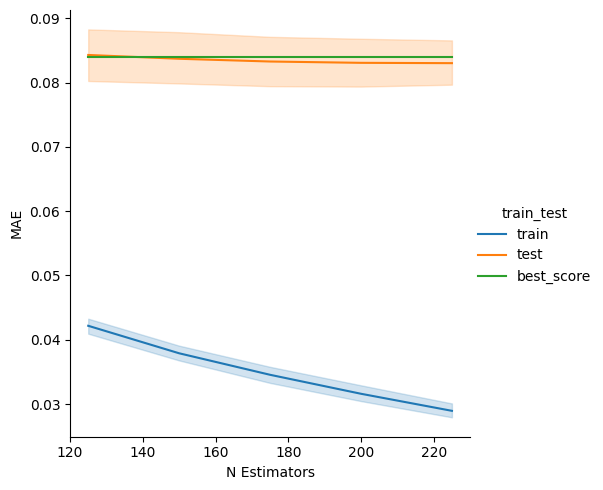

In [44]:
# Defining the best parameters found with GridSearchCV
gscv_best_params = {"colsample_bytree": 0.8, "eval_metric": "mae",
                    "gamma": 0, "lambda": 1, "learning_rate": 0.1, 
                    "max_depth": 4, "n_estimators": 150, "subsample": 1.0, 
                    "random_state":42}

# Defining, for each parameter, a name without special characters and an array with the values to test
main_parameters_dict = {"n_estimators": ["N Estimators", [125, 150, 175, 200, 225]]}

# Iterating over the parameter dictionary
for parameter, arguments in main_parameters_dict.items():
    # Create an empty dataframe for the scores
    df_scores = pd.DataFrame(columns=["value", "train_test", "score"])
    
    print(f"{arguments[0]}\n")
    
    # Depending on the parameter, different models are built
    for parameter_value in arguments[1]:
        # Getting the best parameters found with GridSearchCV
        params_to_use = gscv_best_params.copy()
        # Adding the individual value of the parameter that we want to test
        params_to_use[parameter] = parameter_value
        
        # Create the XGBoost model with the parameters
        model = xgb.XGBRegressor().set_params(**params_to_use)
        
        # Adding the cross validate scores of a parameter value to the df_scores dataframe
        df_scores = get_cross_validate_scores(df_scores=df_scores, feature=arguments[0], value=parameter_value, model=model,
                                              X_train=X_train, y_train=y_train, best_score=best_score)
    
    # Plot the parameter scores
    plot_parameter_scores(arguments[0], df_scores)
    
    print("\n")

### Second Round 

In [42]:
# Using the information gathered before to define the parameters grid
parameters_grid = {'max_depth': [4, 5], 
                   'learning_rate': [0.05, 0.1, 0.15],
                   'n_estimators': [150, 300, 450], 
                   'gamma': [0, 20], 
                   'subsample': [0.7, 1], 
                   'colsample_bytree': [0.7, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

xgboost = xgb.XGBRegressor()

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 1], 'eval_metric': ['mae'],
                         'gamma': [0, 20], 'lambda': [0, 0.1, 1],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [4, 5], 'n_estimators': [150, 300, 450],
                         'subsample': [0.7, 1], 'tree_method': ['hist']},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [43]:
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

,colsample_bytree,eval_metric,gamma,lambda,learning_rate,max_depth,n_estimators,subsample,tree_method,test_mean_mae,train_mean_mae
292,1.0,mae,0,1.0,0.05,4,450,0.7,hist,-0.081397,-0.026233
50,0.7,mae,0,0.1,0.10,4,300,0.7,hist,-0.081534,-0.019089
52,0.7,mae,0,0.1,0.10,4,450,0.7,hist,-0.081675,-0.010709
40,0.7,mae,0,0.1,0.05,4,450,0.7,hist,-0.081750,-0.025409
82,0.7,mae,0,1.0,0.05,5,450,0.7,hist,-0.081809,-0.016516
...,...,...,...,...,...,...,...,...,...,...,...
144,0.7,mae,20,0.1,0.05,4,150,0.7,hist,-0.217746,-0.216485
108,0.7,mae,20,0.0,0.05,4,150,0.7,hist,-0.217801,-0.216374
114,0.7,mae,20,0.0,0.05,5,150,0.7,hist,-0.217801,-0.216374
180,0.7,mae,20,1.0,0.05,4,150,0.7,hist,-0.218395,-0.216621


### Validate the model with the test set

In [51]:
# Calculate the Mean Absolute Error for the Test Set
test_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_gscv.best_estimator_.predict(X_test))

In [52]:
test_mae

0.08082460635530996